In [1]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix

In [3]:
# %run utils.ipynb

%run "C:\Users\johnm\Downloads\utils.ipynb"  #tarang

# Tabular Data

In [ ]:
# df_path = "../marksheet.csv"
df_path =  "../data/marksheet.csv"

In [ ]:
df = pd.read_csv(df_path)

In [ ]:
df.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO


In [ ]:
df['patient_age']

0       73
1       64
2       58
3       72
4       67
        ..
1495    71
1496    81
1497    56
1498    71
1499    56
Name: patient_age, Length: 1500, dtype: int64

## Data Missingness

In [ ]:
missing_values_count = df['patient_age'].isnull().sum()
print(missing_values_count)

0


## Descriptive Stats for all participants

In [ ]:
summary_stats = df['patient_age'].describe()
print(summary_stats)

count    1500.000000
mean       65.595333
std         7.191527
min        35.000000
25%        61.000000
50%        66.000000
75%        70.000000
max        92.000000
Name: patient_age, dtype: float64


## Descriptive Stats for each class

In [ ]:
cancer = df[df['case_csPCa'] == 'YES']
no_cancer = df[df['case_csPCa'] == 'NO']

In [ ]:
summary_stats_cancer = cancer['patient_age'].describe()
print('------Patients with Cancer -----')
print(summary_stats_cancer)

------Patients with Cancer -----
count    425.000000
mean      67.720000
std        6.898127
min       48.000000
25%       64.000000
50%       68.000000
75%       73.000000
max       87.000000
Name: patient_age, dtype: float64


In [ ]:
summary_stats_no_cancer = no_cancer['patient_age'].describe()
print('------Patients without Cancer -----')
print(summary_stats_no_cancer)

------Patients without Cancer -----
count    1075.000000
mean       64.755349
std         7.134819
min        35.000000
25%        60.000000
50%        65.000000
75%        69.000000
max        92.000000
Name: patient_age, dtype: float64


## Plots

/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


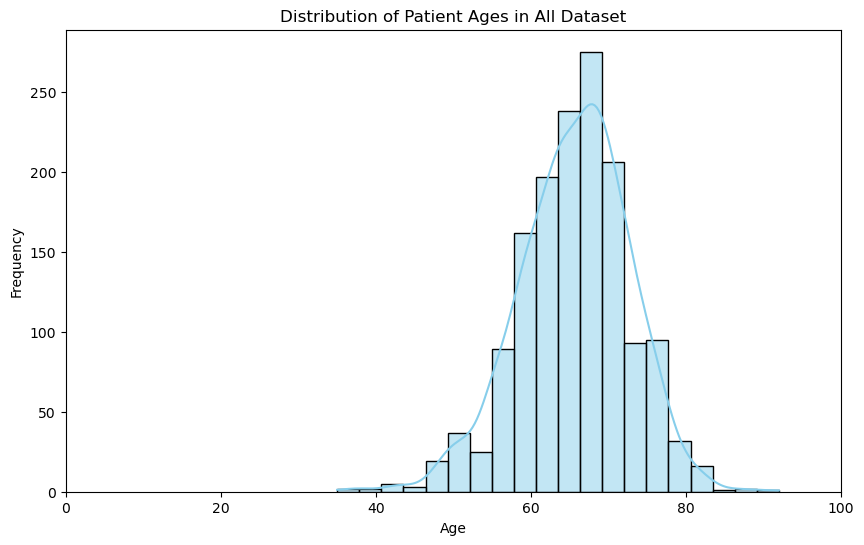

In [ ]:
plot_histogram(df['patient_age'], 'Distribution of Patient Ages in All Dataset', 'Age', 'Frequency', x_range=(0, 100))

/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


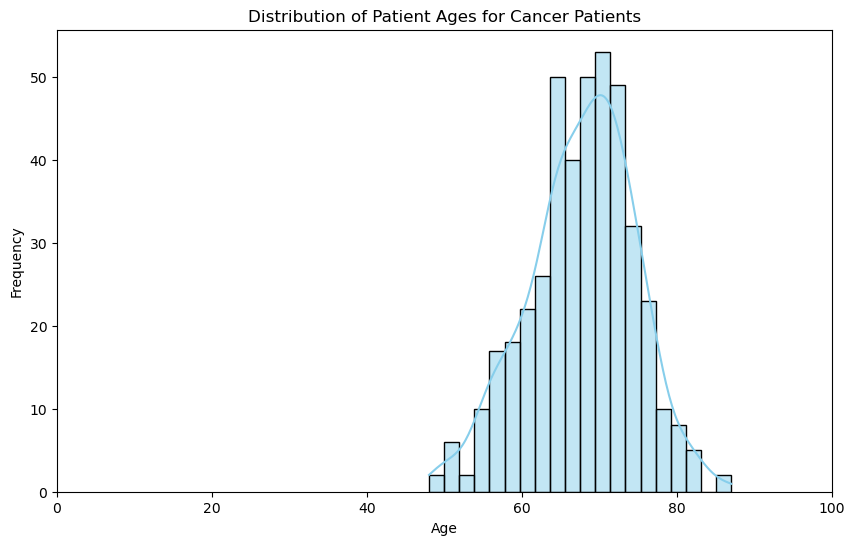

In [ ]:
plot_histogram(cancer['patient_age'], 'Distribution of Patient Ages for Cancer Patients', 'Age', 'Frequency', x_range=(0, 100))

/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emilia/micromamba/envs/cs109b/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


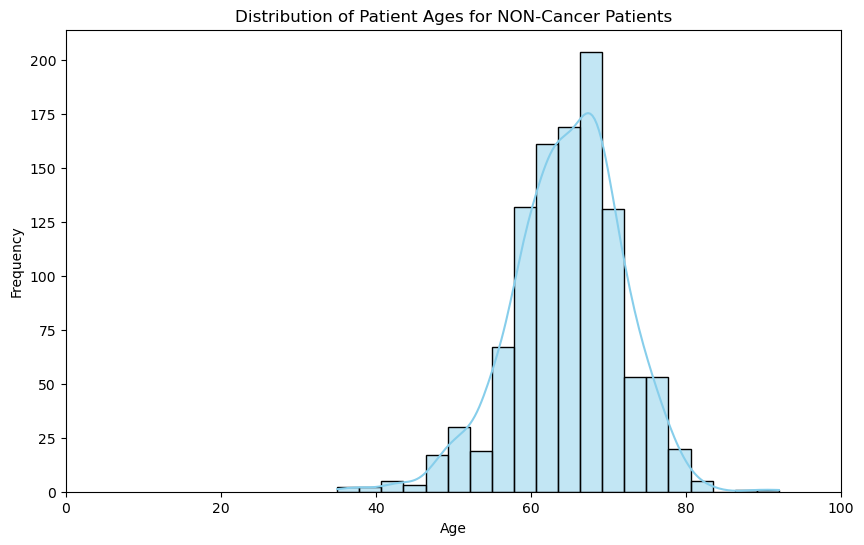

In [ ]:
plot_histogram(no_cancer['patient_age'], 'Distribution of Patient Ages for NON-Cancer Patients', 'Age', 'Frequency', x_range=(0, 100))

# Image Data

In [ ]:
# no / yes stats are in modeling.ipynb

# distribution of number of slices and image sizes for t2w, ax and adc

In [8]:
def get_images(directory, multi_fold = False, dict_images = [{}, {}, {}]):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      get_images(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if 't2w' in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[0][short_name] = {'image': image, 'case_pca': None, 'patient_id': None}
                if 'hbv' in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[1][short_name] = {'image': image, 'case_pca': None, 'patient_id': None}
                if 'adc' in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[2][short_name] = {'image': image, 'case_pca': None, 'patient_id': None}
    return dict_images


In [9]:
dict_images = [{}, {}, {}]

directory = "D:\Downloads\Luna Training Data"
folds = os.listdir(directory)

dict_images = get_images(directory, True, dict_images)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\johnm\AppData\Local\Temp\ipykernel_1068\981189360.py:3: SyntaxWarning: invalid escape sequence '\D'
  directory = "D:\Downloads\Luna Training Data"


fold
D:\Downloads\Luna Training Data\picai_public_images_fold0
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold1
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold2
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold3
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold4
datapoint


In [16]:
def visualize_image(image):
  #this is to display the image
  image_array = sitk.GetArrayFromImage(image)

  # Display slices of the image using Matplotlib
  num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
  fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
  for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
  plt.show()

## Visualizing Random Images

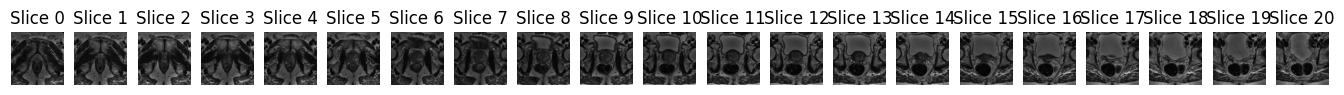

In [21]:
# t2w
visualize_image(dict_images[0][random.choice(list(dict_images[0].keys()))]['image'])

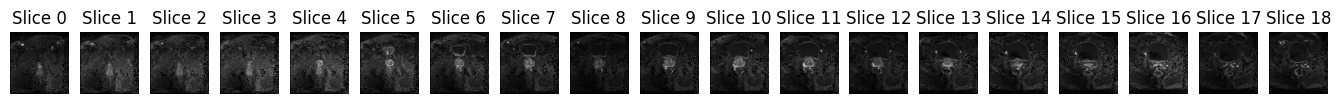

In [22]:
# hbv
visualize_image(dict_images[1][random.choice(list(dict_images[0].keys()))]['image'])

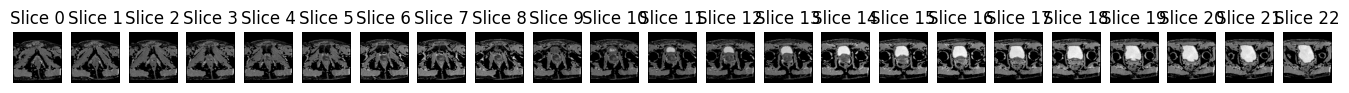

In [23]:
# adc
visualize_image(dict_images[2][random.choice(list(dict_images[0].keys()))]['image'])

## Distribution of Number of Slices & Sizes

In [27]:
num_slices = [[], [], []]
sizes = [[], [], []]

for key in list(dict_images[0].keys()):
  t2w = sitk.GetArrayFromImage(dict_images[0][key]['image'])
  hbv = sitk.GetArrayFromImage(dict_images[1][key]['image'])
  adc = sitk.GetArrayFromImage(dict_images[2][key]['image'])

  num_slices[0].append(t2w.shape[0])
  num_slices[1].append(hbv.shape[0])
  num_slices[2].append(adc.shape[0])

  sizes[0].append(t2w.shape[1:3])
  sizes[1].append(hbv.shape[1:3])
  sizes[2].append(adc.shape[1:3])


In [59]:
# not all patients images have same # of slices (across t2w, adc, hbv)

for i in range(len(num_slices[0])):
  if (num_slices[0][i] != num_slices[1][i]):
      print(num_slices[0][i], num_slices[1][i])
  if (num_slices[1][i] != num_slices[2][i]):
      print(num_slices[1][i], num_slices[2][i])

19 21
25 20
27 16
23 20
25 24
23 21
21 19
21 19
23 21
23 19
27 16
21 19
27 16
27 16
19 20
21 19
29 27
19 20
21 19
18 20
25 20
25 21
27 16
23 19
27 16
19 21
21 19
19 21
19 21
27 16
19 21
21 19
21 19
23 21
21 19
27 16
19 21
23 19
21 19
19 21
21 19
29 27
19 21
21 19
21 19
19 21
19 21
27 16
16 18
19 21
21 19
19 21
27 16
27 16
21 19
19 20
31 27
23 28
27 16
21 19
21 19
21 20
27 16
21 19
27 16
27 16
24 23
21 19
21 20
21 19
28 18
21 19
23 19
21 19
21 19
21 19
27 29
19 21
21 19
21 20
19 21
25 20
21 19
19 18
25 21
21 19
19 21
24 28
23 19
19 20
29 27
27 18
23 19
27 16
23 19
21 19
27 16
27 16
27 16
21 19
27 16
21 19
21 19
23 21
19 21
21 19
29 31
22 19
23 20
23 21
21 19
27 16
21 19
21 19
25 20
25 20
23 21
27 28
21 19
45 30
27 16
21 19
27 16
25 23
31 22
21 19
23 19
19 20
19 21
23 21
19 20
19 21
27 16
27 16
25 23
21 19
21 19
27 16
23 21
27 16
23 28
25 28
23 19
21 19
27 21
19 20
19 21
21 19
31 27
21 19
21 23
21 19
27 16
21 19
21 19
19 21
19 21
27 20
20 27
23 19
21 20
23 21
27 16
29 27
21 19
21 19
21 2

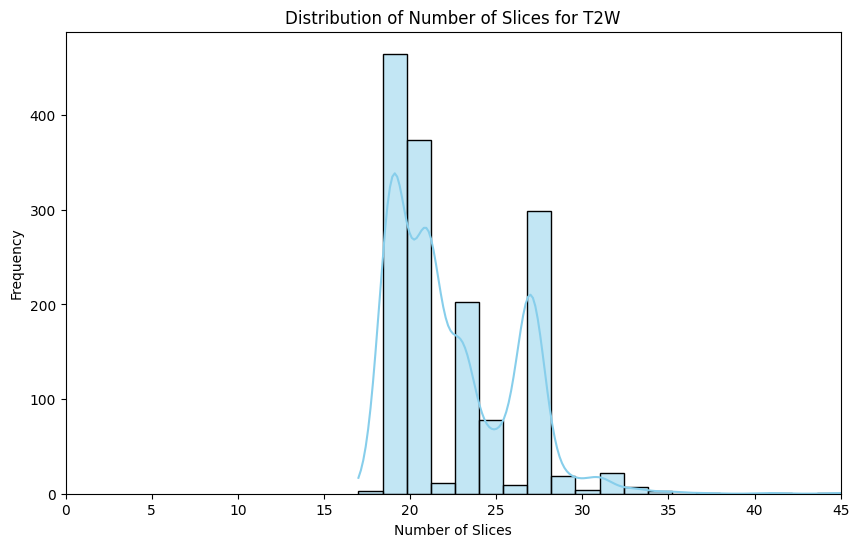

In [40]:
plot_histogram(num_slices[0], 'Distribution of Number of Slices for T2W', 'Number of Slices', 'Frequency', x_range=(0, max(num_slices[0])))

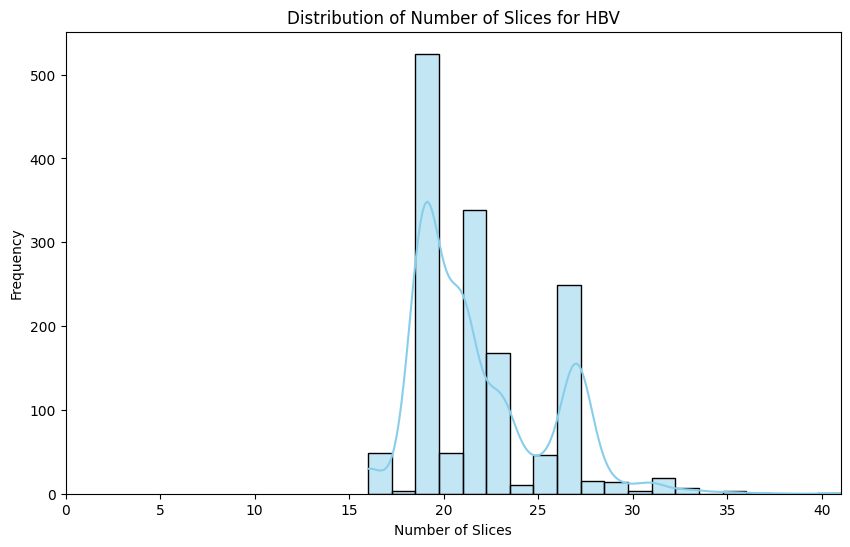

In [41]:
plot_histogram(num_slices[1], 'Distribution of Number of Slices for HBV', 'Number of Slices', 'Frequency', x_range=(0, max(num_slices[1])))

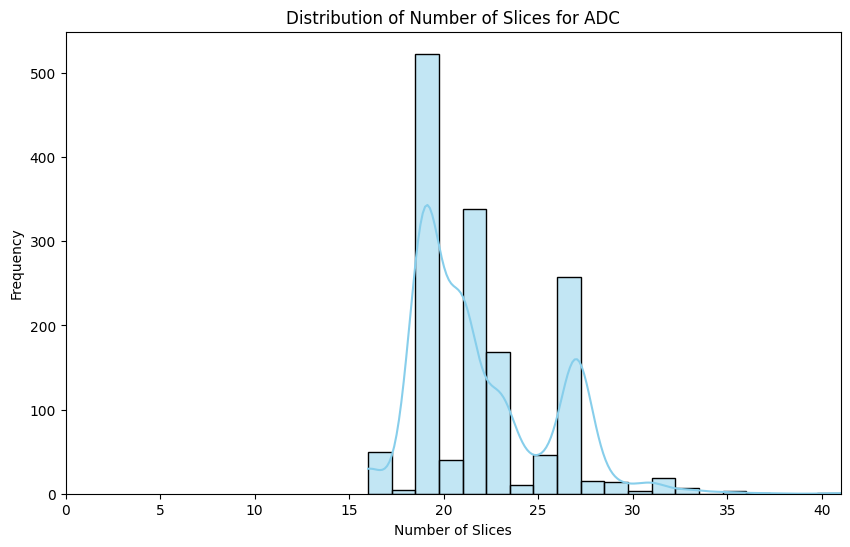

In [42]:
plot_histogram(num_slices[2], 'Distribution of Number of Slices for ADC', 'Number of Slices', 'Frequency', x_range=(0, max(num_slices[2])))

In [45]:
# are all the images squares?

t2w = False
hbv = False
adc = False

for i in range(len(num_slices[0])):
  if (sizes[0][i][0] != sizes[0][i][1] and not t2w):
    print("non-square t2w")
    t2w = True
  if (sizes[1][i][0] != sizes[1][i][1] and not hbv):
    print("non-square hbv")
    hbv = True
  if (sizes[2][i][0] != sizes[2][i][1] and not adc):
    print("non-square adc")
    adc = True

non-square hbv
non-square adc


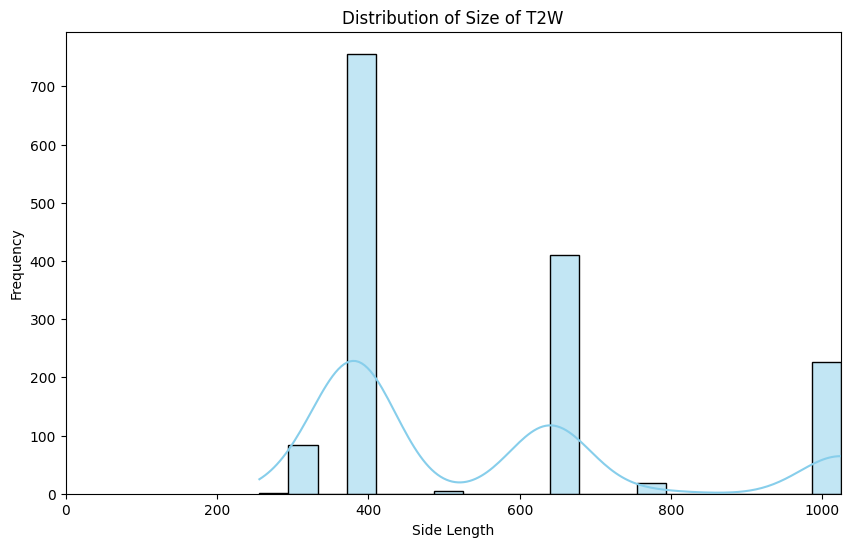

In [50]:
t2w_side = [sizes[0][i][0] for i in range(len(sizes[0]))]

plot_histogram(t2w_side, 'Distribution of Size of T2W', 'Side Length', 'Frequency', x_range=(0, max(t2w_side)))

Text(0.5, 1.0, 'Distribution of Size of HBV')

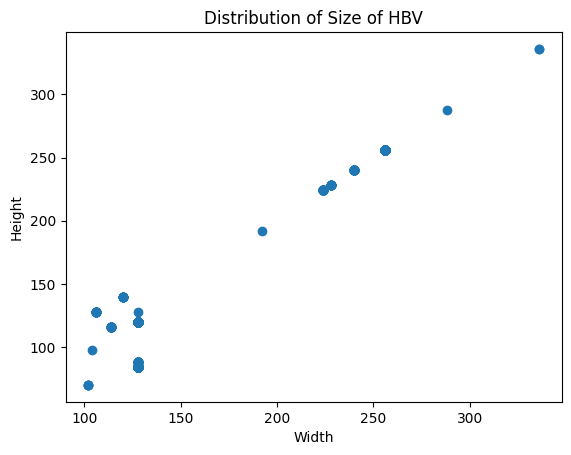

In [55]:
x = [sizes[1][i][0] for i in range(len(sizes[0]))]
y = [sizes[1][i][1] for i in range(len(sizes[0]))]

plt.scatter(x, y)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Size of HBV")

Text(0.5, 1.0, 'Distribution of Size of ADC')

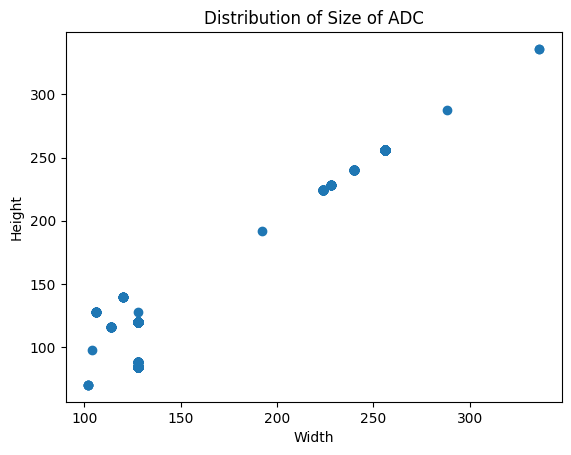

In [56]:
x = [sizes[2][i][0] for i in range(len(sizes[0]))]
y = [sizes[2][i][1] for i in range(len(sizes[0]))]

plt.scatter(x, y)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Size of ADC")